<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span><ul class="toc-item"><li><span><a href="#Download-data-(if-needed)" data-toc-modified-id="Download-data-(if-needed)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download data (if needed)</a></span></li><li><span><a href="#Read-in-log-file" data-toc-modified-id="Read-in-log-file-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read in log file</a></span></li><li><span><a href="#Read-in-images-by-path-from-log-file" data-toc-modified-id="Read-in-images-by-path-from-log-file-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read in images by path from log file</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import cv2

# Load the Data

We'll load the log data & also load the images (found in the log file).

## Download data (if needed)

In [2]:
# Download data & unzip if it doesn't already exist
import os.path
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [3]:
def load_ext_file(data_zip_url, data_path='data/'):
    '''Download the zip file from URL and extract it to path (if specified).
    '''
    # Check if path already exits
    if not os.path.exists(data_path):
        with urlopen(data_zip_url) as zip_resp:
            with ZipFile(BytesIO(zip_resp.read())) as zfile:
                # Extract files into the data directory
                zfile.extractall(path=None)
       

In [4]:
# Zip file contains the "data" and "__MACOSX" directories
load_ext_file(
    'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip',
    data_path='data/'
)

## Read in log file

In [5]:
def create_img_meas_dfs(log_csv, data_dir=None, orig_dir=None, skiprows=None):
    '''Creates DataFrames for the image paths and measurements using CSV path.
    
    Returns tuple of two DataFrames.
    '''
    data_header = [
        'image_center',
        'image_left',
        'image_right',
        'steer_angle', # [-1,1]
        'throttle', # boolen (if accelerating)
        'break', # boolean (if breaking)
        'speed' # mph
    ]

    df = pd.read_csv(
        log_csv,
        names=data_header,
        skiprows=skiprows
    )

    # Replace the original directory from dataset (if specified)
    if orig_dir and data_dir:
        for col in ['image_center','image_left','image_right']:
            df[col] = df[col].str.replace(orig_dir,data_dir)
    
    # Get specifics for each DF
    df_img_paths = df.iloc[:,:3]
    df_measurments = df.iloc[:,3:]
    
    return df_img_paths,df_measurments

In [6]:
df_imgs, df_meas = create_img_meas_dfs(log_csv='data/driving_log.csv',skiprows=1)

display(df_imgs.head())

print('Stats for measurements:')
display(df_meas.describe())

,image_center,image_left,image_right
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg


Stats for measurements:


,steer_angle,throttle,break,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


## Read in images by path from log file

In [28]:
center_images = []
left_images = []
right_images = []

# TODO: Slow and inefficient process
# Iterate over the different images
data_dir = 'data/'
for index,row in df_imgs.iterrows():
    center_images.append(cv2.imread(data_dir+row['image_center'].strip()))
    left_images.append(cv2.imread(data_dir+row['image_left'].strip()))
    right_images.append(cv2.imread(data_dir+row['image_right'].strip()))

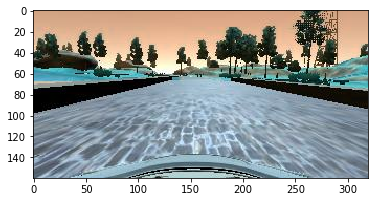

In [29]:
# Test to see if image reading works
import matplotlib.pyplot as plt


plt.imshow(center_images[0])
# plt.imshow(left_images[0])
# plt.imshow(right_images[0])